In [1]:
import numpy as np
import time
import random
import pylab
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Number of training cycles
episodes = 50000

# Hrr parameters
hrr_length = 2048
normalized = True

# How many steps to take before quiting
steps_till_quit = 100

#goals = [2, 6, 12]
goals = [5, 10, 15]

# Maze parameters
size_of_maze = 20
non_obs_task_switch_rate = 250
num_non_obs_tasks = len(goals)

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.75
alpha = 0.1

# Reward for temporal difference learning
reward_bad = 0
reward_good = 1

# Expolration rate
e_soft = 0.0001

# Threshold for non observable task switching
threshold_negative = -0.3
treshold_positive = 0.8

# Print frequency
p_freq = 1000

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.0

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

rand_on = 1

debug = False

In [3]:
def get_moves(state, size_of_maze):
    if(state == 0):
        return size_of_maze - 1, 1
    elif(state == size_of_maze - 1):
        return size_of_maze - 2, 0
    else:
        return state - 1, state + 1

In [4]:
ltm = LTM(hrr_length, normalized)

In [5]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]


In [6]:
def context_policy_negative(atr):
    return (atr + 1)%num_non_obs_tasks

def context_policy_positive(state):
    val = -9999
    temp = -9999
    for atr in range(0, num_non_obs_tasks):
        encode_str = build_hrr_string(state, atr)
        temp = np.dot(weights, ltm.encode(encode_str)) + bias
        if temp > val:
            val = temp
            s_atr = atr
    return s_atr

def build_hrr_string(state, atr):
    return "State:" + str(state) + "*" + "Atr:" + str(atr)
    
def move_policy(moves, atr, rand_on):
    
    val = -9999
    temp = -9999
    
    for move in moves:
        if move == goal:
            encode_str = build_hrr_string(str(move) + "*rewardTkn", atr)
        else:
            encode_str = build_hrr_string(move, atr)
        temp = np.dot(weights, ltm.encode(encode_str)) + bias
        if(debug):
            print("State {0} value {1}".format(move, temp))
        if temp > val:
            val = temp
            s_move = move
            
    # Random move
    if((np.random.random_sample() < e_soft) and (rand_on == 1)):
        if(debug):
            print("RANDOM MOVE")
        return (np.random.choice(moves), val, 1)
    
    return (s_move, val, 0)

def logmod(x):
    return np.sign(x)*np.log(abs(x)+1)

def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

In [7]:
t0 = time.time()
non_obs = 0
opt_count = 0
current_atr = 0
debug2 = False
step_store = []

for x in range(episodes):
    
#     if x > 49990:
#         debug = True
    
    # Starting state
    current_state = random.randint(0, size_of_maze - 1)
    start = current_state

    last_non_obs = non_obs
    if x%non_obs_task_switch_rate == 0:
        non_obs = (non_obs+1)%num_non_obs_tasks
    
    goal = goals[non_obs]
    
    steps = 0
    opt_steps = get_opt_steps(start, goal, size_of_maze)
    
    # Reset trace
    eligibility *= 0.0
    
    if x > ((episodes * 8) / 10) :
        debug2 = True
        rand_on = 0
        alpha = 0.01
    
    if(debug):
        print("Start state {0} with goal State {1} and atr {2} with task {3}".format(current_state, goal, current_atr, non_obs))

    episode_memory = []
    for y in range(steps_till_quit):
        # Goal reached
        if (current_state == goal):
            encode_str = build_hrr_string(str(current_state) + "*rewardTkn", current_atr)
            goal_hrr = ltm.encode(encode_str)
            goal_value = np.dot(weights, goal_hrr) + bias  
            episode_memory += [[current_state, current_value, goal]]

            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * logmod(error) * eligibility))
            
            if(debug):
                print("In goal with value {0}".format(goal_value))
            
            break
            
        previous_state = current_state
        previous_atr = current_atr 
        
        encode_str = build_hrr_string(previous_state, previous_atr)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = np.dot(weights, previous_state_hrr) + bias
        episode_memory += [[previous_state, previous_value, goal]]
        
        left, right = get_moves(previous_state, size_of_maze)
        move, max_value, random_move = move_policy([left, right], previous_atr, rand_on)
        steps += 1
        
        if random_move:
            eligibility *= 0.0
        
        if(debug):
            print("Moves {0}, taken {1}".format([left, right], move))
        
        current_state = move
        current_atr = current_atr
        
        if current_state == goal:
            encode_str = build_hrr_string(str(current_state) + "*rewardTkn", current_atr)
        else:
            encode_str = build_hrr_string(str(current_state), current_atr)
            
        current_state_hrr = ltm.encode(encode_str)
        current_value = np.dot(weights, current_state_hrr) + bias
        
        q_error = (reward_bad + discount * max_value) - previous_value
        sarsa_error = (reward_bad + discount * current_value) - previous_value
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        if sarsa_error > treshold_positive:
            current_atr = context_policy_positive(current_state)
            weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
            eligibility *= 0.0
            steps = 0
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        if sarsa_error < threshold_negative:
            current_atr = context_policy_negative(previous_atr)
            # err2 = reward_bad - previous_value
            # weights = np.add(weights, (alpha * logmod(err2) * previous_state_hrr))
            # weights = np.add(weights, (alpha * logmod(error) * previous_state_hrr))
            weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
            eligibility *= 0.0
            steps = 0
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        weights = np.add(weights, (alpha * sarsa_error * eligibility))
        
        if(debug):
            input("Enter")

    # if debug2 and steps-opt_steps:
    #    print(np.array(episode_memory))
            
    if(debug):
        print("steps taken {}, opt steps {}".format(steps, opt_steps))
        input("Enter")
        
    if(debug2):
        step_store += [steps - opt_steps]
        
    if(debug):
        input("Enter\n\n")
        
    if((x+1)%p_freq == 0):
        print("Episode" , x+1, "done")

Episode 1000 done
Episode 2000 done
Episode 3000 done
Episode 4000 done
Episode 5000 done
Episode 6000 done
Episode 7000 done
Episode 8000 done
Episode 9000 done
Episode 10000 done
Episode 11000 done
Episode 12000 done
Episode 13000 done
Episode 14000 done
Episode 15000 done
Episode 16000 done
Episode 17000 done
Episode 18000 done
Episode 19000 done
Episode 20000 done
Episode 21000 done
Episode 22000 done
Episode 23000 done
Episode 24000 done
Episode 25000 done
Episode 26000 done
Episode 27000 done
Episode 28000 done
Episode 29000 done
Episode 30000 done
Episode 31000 done
Episode 32000 done
Episode 33000 done
Episode 34000 done
Episode 35000 done
Episode 36000 done
Episode 37000 done
Episode 38000 done
Episode 39000 done
Episode 40000 done
Episode 41000 done
Episode 42000 done
Episode 43000 done
Episode 44000 done
Episode 45000 done
Episode 46000 done
Episode 47000 done
Episode 48000 done
Episode 49000 done
Episode 50000 done


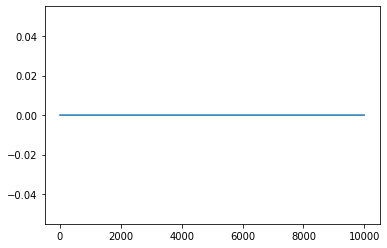

100.0

In [8]:
plt.plot(step_store)
plt.show()
(len(step_store)-np.count_nonzero(step_store))*100.0 / len(step_store)

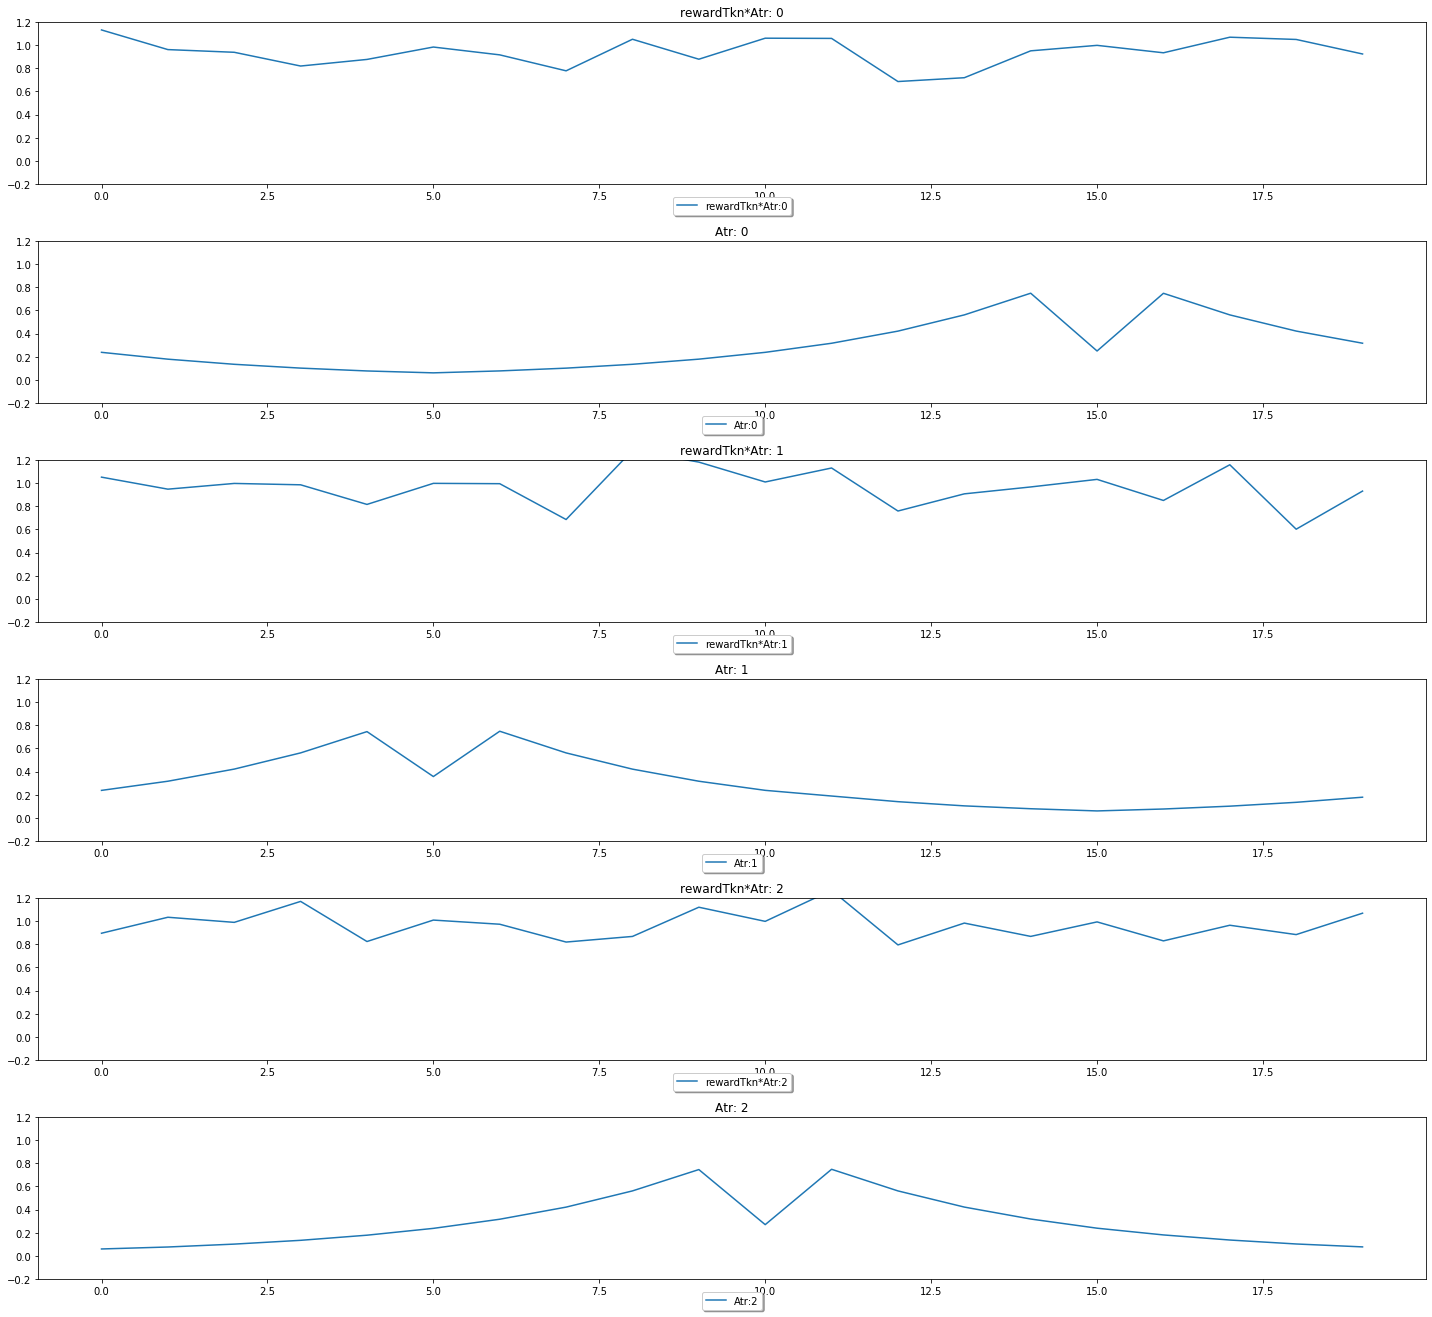

In [9]:
fig, axes = plt.subplots(nrows=num_non_obs_tasks * 2, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(20)

for x in range(num_non_obs_tasks):
    
    x_ind = x * 2
    
    y_for_rwd = 0
    y_for_no_rwd = 0
    
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    lab = "rewardTkn*Atr:" + str(x)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(str(state) + "*rewardTkn", x)
        value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
    axes[x_ind].title.set_text("rewardTkn*" + "Atr: " + str(x))
    axes[x_ind].set_ylim([-0.2, 1.2])
    axes[x_ind].plot(position, value, label=lab)
        
    axes[x_ind].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
    
    
    y = x + 1
    
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    lab = "Atr:" + str(x)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(str(state), x)
        value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
    axes[x_ind+1].title.set_text("Atr: " + str(x))
    axes[x_ind+1].set_ylim([-0.2, 1.2])
    axes[x_ind+1].plot(position, value, label=lab)
    
    axes[x_ind+1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        fancybox=True, shadow=True, ncol=1, prop={'size': 10})
    y_for_no_rwd += 1
    
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
t1 = time.time()

In [10]:
total = t1-t0
print(total / 60)

0.34562037388483685


In [11]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]
Atr:0 [-0.03581135  0.02231949  0.00371651 ... -0.01347276 -0.03135999
 -0.0255344 ]
State:2 [ 0.00717717 -0.02028569  0.04936846 ...  0.01113581  0.0054777
 -0.00939032]
Atr:0*State:2 [ 0.01555338 -0.03783677  0.00939733 ... -0.00090823 -0.00644375
 -0.02045959]
State:1 [ 0.00052014  0.03406334 -0.00999316 ... -0.00393329  0.00254118
  0.01738073]
Atr:0*State:1 [-0.01437903  0.00563084  0.00626743 ...  0.00229322 -0.00404298
 -0.03388456]
State:3 [-0.01345346 -0.00033556 -0.03939343 ...  0.02569185  0.0118189
 -0.01741774]
Atr:0*State:3 [-0.00168967  0.02253871  0.01422821 ... -0.00890968 -0.0061947
 -0.01715506]
State:0 [ 0.03248882 -0.00244752  0.00937283 ... -0.01746188 -0.02195372
 -0.0199523 ]
Atr:0*State:0 [ 0.03376735  0.02733032  0.03997259 ...  0.00258094 -0.01437645
  0.0007115 ]
State:19 [-0.02825932 -0.02462034 -0.01295464 ...  0.00590349 -0.0080545
 -0.02385507]
Atr:0*State:19 [ 0.0375628  -0.00561485 -0.02304587 ...  0.0057054   0.00203741
 -0.0

In [12]:
del ltm